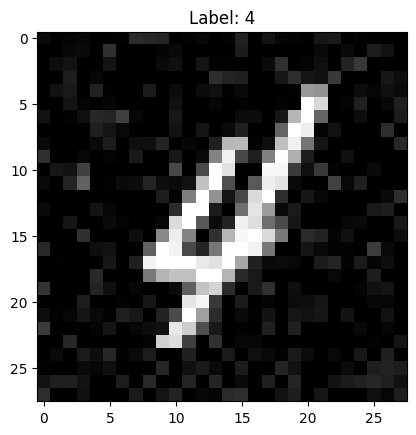

In [3]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a function to add Gaussian noise to images
def add_gaussian_noise(img, mean=0., std=0.1):
    noise = torch.randn(img.size()) * std + mean
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)  # Make sure pixel values remain between 0 and 1

# Define the transformations: convert to tensor and add noise
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_gaussian_noise(x))
])

# Load the MNIST dataset with noise
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Check one example from the dataset
images, labels = next(iter(train_loader))
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.show()


In [4]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Log-variance
        
        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)  # Return mean and log-variance
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Return reparameterized latent vector

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))  # Sigmoid for pixel values between 0 and 1

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))  # Flatten input images
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [5]:
# Define the loss function for VAE
def vae_loss_function(recon_x, x, mu, logvar):
    # Binary Cross-Entropy for reconstruction loss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL Divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD


In [14]:
import torch
import torch.nn.functional as F
import math

# Function to calculate MSE (with shape matching)
def calculate_mse(original, denoised):
    # Flatten the input images to the same shape as the output from the VAE (784)
    original = original.view(-1, 784)  # Flatten input images to match VAE output
    denoised = denoised.view(-1, 784)  # Ensure the denoised images are flattened
    
    # Calculate MSE loss between original and denoised images
    mse = F.mse_loss(denoised, original)
    return mse.item()

# Function to calculate PSNR
def calculate_psnr(mse, max_pixel_value=1.0):
    psnr = 10 * math.log10(max_pixel_value**2 / mse)  # Use math.log10() for scalar
    return psnr

# PSNR Testing Function
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    psnr_total = 0
    with torch.no_grad():  # No gradient computation in test mode
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, _, _ = model(data)  # Forward pass to get denoised images
            
            # Calculate MSE for the batch (after reshaping)
            mse = calculate_mse(data, recon_batch)
            # Calculate PSNR based on the MSE
            psnr = calculate_psnr(mse)
            
            psnr_total += psnr
    
    # Average PSNR across the test dataset
    avg_psnr = psnr_total / len(test_loader)
    
    print(f"Average PSNR: {avg_psnr:.2f} dB")



Epoch 1, Loss: 244.61066077473959
Epoch 2, Loss: 222.47713430989583
Epoch 3, Loss: 219.090485546875
Epoch 4, Loss: 217.5192720784505
Epoch 5, Loss: 216.74273818359376
Epoch 6, Loss: 216.09757203776041
Epoch 7, Loss: 215.7178459391276
Epoch 8, Loss: 215.3173389811198
Epoch 9, Loss: 215.0032702392578
Epoch 10, Loss: 214.78391403808592
Epoch 11, Loss: 214.52418236490885
Epoch 12, Loss: 214.30985948079427
Epoch 13, Loss: 214.09075282389324
Epoch 14, Loss: 213.91415771484375
Epoch 15, Loss: 213.80696768391928
Epoch 16, Loss: 213.61909165039063
Epoch 17, Loss: 213.47956586914063
Epoch 18, Loss: 213.31922438151042
Epoch 19, Loss: 213.15940814615885
Epoch 20, Loss: 213.07428513997397
Epoch 21, Loss: 212.89029300130207
Epoch 22, Loss: 212.84100299479167
Epoch 23, Loss: 212.7382182454427
Epoch 24, Loss: 212.6725401936849
Epoch 25, Loss: 212.5085410970052
Epoch 26, Loss: 212.4846581705729
Epoch 27, Loss: 212.4273530110677
Epoch 28, Loss: 212.3282546875
Epoch 29, Loss: 212.27128032226562
Epoch 30,

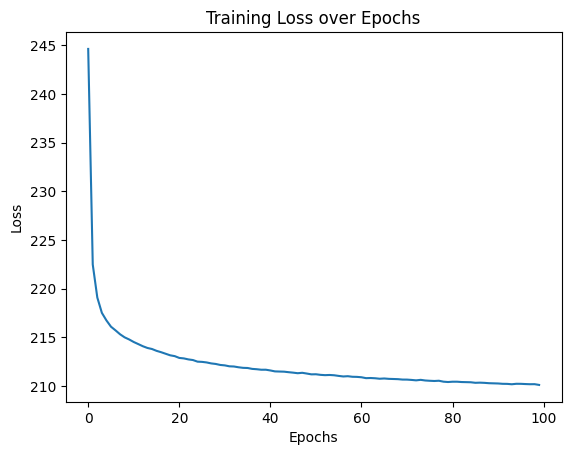

Average PSNR: 17.86 dB


In [15]:
# Initialize the model, optimizer, and move model to device (GPU/CPU)
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop with 100 epochs and loss tracking
def train_and_plot(model, train_loader, optimizer, num_epochs=100):
    train_losses = []
    
    for epoch in range(1, num_epochs + 1):  # 100 epochs
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, logvar = model(data)

            # Compute loss and backpropagate
            loss = vae_loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        # Average loss per epoch
        avg_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch}, Loss: {avg_loss}')
    
    # Plotting the training loss over time
    plt.plot(train_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

# Train and plot loss for 100 epochs
train_and_plot(model, train_loader, optimizer, num_epochs=100)

# Test the model with PSNR on the test dataset
test_model(model, test_loader)


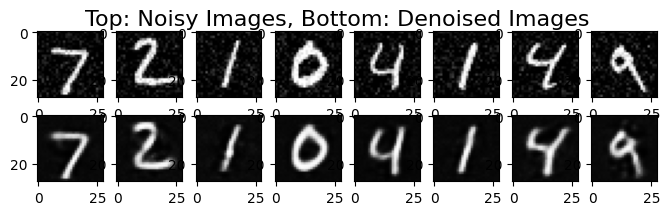

In [15]:
# Visualize the denoising results
def visualize_results(model, test_loader):
    model.eval()
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, _, _ = model(data)
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch.view(64, 1, 28, 28)[:n]])
                break
    
    comparison = comparison.cpu().numpy()
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(n, 2))
    
    # Top row: Noisy inputs, Bottom row: Denoised outputs
    fig.suptitle('Top: Noisy Images, Bottom: Denoised Images', fontsize=16)
    
    for j in range(n):
        axes[0, j].imshow(comparison[j][0], cmap='gray')
        axes[1, j].imshow(comparison[j + n][0], cmap='gray')

    plt.show()

# Visualize the results on the test dataset
visualize_results(model, test_loader)
